# Skim Formatted Issue Pages

Recent work in information visualization has described using font attributes as a way to encode information in text. In particular, [Brath and Banissi (2015)](http://vialab.science.uoit.ca/textvis2015/papers/Brath-textvis2015.pdf) have proposed "skim formatted" documents, using font attributes to foreground important or unusual words. See a figure from the linked paper below.

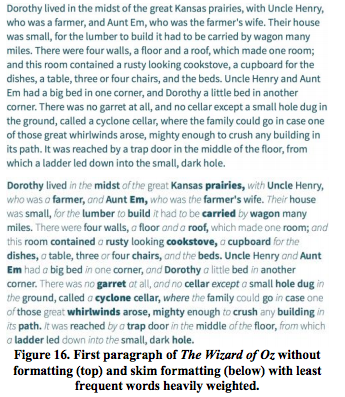

In [1]:
from IPython.display import Image
Image(filename='skim_formatting.png') 

A potentially interesting domain for this type of document could be political candidate issue pages — web pages where political candidates detail their positions on various issues. Some work has explored how political information seekers use these types of pages, such as how exposure political ads may dissuade information seekers from seeking out more information on these pages ([Valentino, Hutchings, and Williams, 2004](https://www.researchgate.net/profile/Nicholas_Valentino/publication/269828099_The_Impact_of_Political_Advertising_on_Knowledge_Internet_Information_Seeking_and_Candidate_Preference/links/54c793490cf22d626a36a36f.pdf))
or how differing motiviations affect information seeking online ([Kim, 2007](http://crx.sagepub.com/content/34/2/185.full.pdf)).

Skimmable documents may be of use when information seekers are comparing two candidates who have relatively similar positions. This is to say, utilizing font attributes as proposed by Brath and Banissi could be a useful way to foreground text that best differentiates two candidates, while allowing them to ignore text that is relatively consistent across candidates. The popularity of sites like [BallotReady](https://www.ballotready.org/) in the last election suggests voters do value easy to parse comparisons of candidates.

Below, I provide an example of what a skimmable issue page may look like. Using issue pages from Bernie Sanders and Hillary Clinton I use a simple technique from information retrieval to assign differentiation scores to each sentence on a page. I then create skim formatted pages by changing font colors of the pages, such that darker sentences represent sentences that most differentiate the candidates.

For a quick example, I download the HTML from both Hillary Clinton and Bernie Sanders' page on LGBT issues and manually extract the issue text using `BeautifulSoup`. We can view these two documents side by side.

In [2]:
from IPython.display import display, HTML
import urllib2
from bs4 import BeautifulSoup

hillary_url = "https://www.hillaryclinton.com/issues/lgbt-equality/"
bernie_url = "https://berniesanders.com/issues/fighting-for-lgbt-equality/"

hillary_raw_html = urllib2.urlopen(urllib2.Request(hillary_url, headers= { 
            'User-Agent': "Mozilla/5.0" })).read()
bernie_raw_html = urllib2.urlopen(urllib2.Request(bernie_url, headers= { 
            'User-Agent': "Mozilla/5.0" })).read()

hillary_soup = BeautifulSoup(hillary_raw_html, "html.parser")
bernie_soup = BeautifulSoup(bernie_raw_html, "html.parser")

hillary_article = hillary_soup.findAll("article", {"class": "o-wrap-article"})[1]
bernie_article = bernie_soup.find("article")
hillary_article.find("div").decompose()
for a in hillary_article.findAll("a"):
    a.decompose()

display_html = '''
<html style="width:100%%">
<body style="width:100%%">
<div style="display:inline-block;width:40%%;margin-right:20px;border:1px solid black;height:400px;overflow:scroll">%s</div>

<div style="display:inline-block;width:40%%;border:1px solid black;height:400px;overflow:scroll">%s</div>
</body>
</html>
''' % (hillary_article, bernie_article)

display(HTML(display_html))

Below, we get split each document into sentences using the `sent_tokenize` function from `nltk`. We then apply the TextRank algorithm ([Mihalcea & Tarau, 2004](http://digital.library.unt.edu/ark:/67531/metadc30962/m2/1/high_res_d/Mihalcea-2004-TextRank-Bringing_Order_into_Texts.pdf)) to all these sentences. In short, we treat each sentence as a document and compute the tf-idf of each word using `TfidfVectorizer` from `sklearn`. We then use these values to get a similarity matrix, where each row and column represent a sentence, and the value of _n<sub>i,j</sub>_ in this matrix represents the similarity between sentence _i_ and sentence _j_. We use `networkx` to read this matrix as a weighted graph, and compute PageRank of each sentence in this graph.

This method was developed with the intended use of document summarization, such that highly ranked sentences would be those extracted for a summary. In our case, we assign a score to every sentence, and then use the `scipy.stats.percentileofscore` function to get the percentile rank of each sentence score. We use these percentile ranks to re-write the HTML from before such that highly ranked sentences are darker and lower ranked sentences are lighter.

In [3]:
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem.snowball import SnowballStemmer
import nltk
import re
from scipy import stats
import networkx as nx

def tokenize_and_stem(text):
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    stems = [stemmer.stem(t) for t in filtered_tokens]
    return stems

stemmer = SnowballStemmer("english")
tfidf = TfidfVectorizer(tokenizer=tokenize_and_stem, stop_words='english', decode_error='ignore')
colors = ["#d3d3d3", "#343434", "#696969", "#9e9e9e", "#000000"]
def get_color_from_percent(percent):
    if percent < 20:
        return colors[0]
    elif percent < 40:
        return colors[1]
    elif percent < 60:
        return colors[2]
    elif percent < 80:
        return colors[3]
    else:
        return colors[4]

def colorize(sents, scores, html):
    new_html = str(html).decode('utf-8')
    for i, sentence in enumerate(sents):
        score = scores[i]
        percentile = stats.percentileofscore(scores, score)
        color = get_color_from_percent(percentile)
        new_html = new_html.replace(sentence, u'<font color = {0}>{1}</font>'.format(color, sentence))
    return new_html

hillary_text = hillary_article.text
bernie_text = bernie_article.text
bernie_sents = nltk.sent_tokenize(bernie_text)
hillary_sents = nltk.sent_tokenize(hillary_text)
tdm = tfidf.fit_transform(bernie_sents + hillary_sents)
similarity_graph = tdm * tdm.T
nx_graph = nx.from_scipy_sparse_matrix(similarity_graph)
nx_scores = nx.pagerank(nx_graph)
bernie_scores = list(nx_scores.iteritems())[:len(bernie_sents)]
hillary_scores = list(nx_scores.iteritems())[len(bernie_sents):]

colorized_hillary_html = colorize(hillary_sents, [a[1] for a in hillary_scores], hillary_article)
colorized_bernie_html = colorize(bernie_sents, [a[1] for a in bernie_scores], bernie_article)

The same HTML from above is shown below with our skim formatting applied.

In [4]:
display_html = '''
<html style="width:100%%">
<body style="width:100%%">
<div style="display:inline-block;width:40%%;margin-right:20px;border:1px solid black;height:400px;overflow:scroll">%s</div>

<div style="display:inline-block;width:40%%;border:1px solid black;height:400px;overflow:scroll">%s</div>
</body>
</html>
''' % (colorized_hillary_html, colorized_bernie_html)

display(HTML(display_html))

You can imagine using different algorithms to assign scores to sentences, such as statistical learning methods to compute a score for each sentence on how predictive it is of a candidate. Examples of documents formatted using this way are online [here](http://matthewheston.com/etc/compare_candidates/sidebyside/).

The example here is brief, but I believe it demonstrates an interesting information visualization technique that may help political information seekers more easily compare candidates. Empirical work could test different sentence scoring methods as well as evaluate different skim formatting techniques using other font attributes rather than just color.